<a href="https://colab.research.google.com/github/YKG-123/Fantasy_football_ML_Random_forest_Regressor/blob/main/QB_Prev_Season_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

In [8]:
file_path = "weekly_player_stats_offense.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)

import requests

years = range(2016, 2024)
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

adp_all = pd.concat(all_adp, ignore_index=True)

adp_all["name"] = adp_all["name"].str.strip()

print(adp_all.head())

adp_all.to_json("historical_adp_ppr.json", orient="records")


adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",
        }))

df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

print(df[["player_name", "season", "adp", "position", "team"]].head())


/tmp/ipython-input-936254132.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     play

In [9]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])
df=df[df["position"]=="QB"]
df=df[df["fantasy_points_ppr"]>11]
df["fantasy_points_ppr"].describe()


15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64


,fantasy_points_ppr
count,2854.000000
mean,22.630750
std,8.059805
min,11.020000
25%,16.340000
50%,21.290000
75%,27.615000
max,55.460000


Train R²: 0.652
Test R²: 0.525


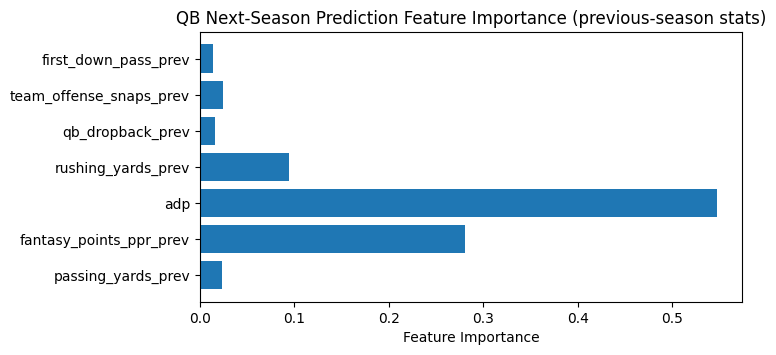


Top predictions (sorted by predicted value):
      player_id      player_name  season  target_season_actual  \
180  00-0034857       Josh Allen    2021                500.98   
164  00-0033873  Patrick Mahomes    2022                566.22   
179  00-0034857       Josh Allen    2020                508.88   
181  00-0034857       Josh Allen    2022                473.68   
163  00-0033873  Patrick Mahomes    2021                487.34   
155  00-0033537   Deshaun Watson    2019                382.58   
156  00-0033537   Deshaun Watson    2020                430.32   
28   00-0023459    Aaron Rodgers    2020                532.84   
71   00-0029263   Russell Wilson    2018                339.58   
73   00-0029263   Russell Wilson    2020                424.86   
90   00-0029701   Ryan Tannehill    2020                409.36   
187  00-0035228     Kyler Murray    2021                338.72   
162  00-0033873  Patrick Mahomes    2020                501.50   
186  00-0035228     Kyler Murr

In [10]:


df = df[df['position'] == 'QB'].copy()

df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)

if 'fantasy_points_ppr' in df.columns:
    df['fantasy_points_ppr'] = df['fantasy_points_ppr'].astype(float)
    fantasy_points_col = 'fantasy_points_ppr'
elif 'season_average_fantasy_points_ppr' in df.columns:
     df['season_average_fantasy_points_ppr'] = df['season_average_fantasy_points_ppr'].astype(float)
     fantasy_points_col = 'season_average_fantasy_points_ppr'
else:
    raise KeyError("No suitable fantasy points column found in the dataframe.")


numeric_cols = df.select_dtypes(include='number').columns.tolist()
group_cols = ['player_id', 'season']
agg_cols = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr"}
agg_cols['fantasy_points_ppr'] = 'sum'


season_agg = df.groupby(group_cols).agg(
    agg_cols
).reset_index()

if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
prev = prev.add_suffix('_prev')
curr = season_agg.copy()
merged_prev_next = curr.merge(
    prev,
    left_on=['player_id', 'season'],
    right_on=['player_id_prev', 'season_prev'],
    how='inner'
)




features = [    'passing_yards_prev', 'fantasy_points_ppr_prev', 'adp',
            "rushing_yards_prev","qb_dropback_prev","team_offense_snaps_prev","first_down_pass_prev"
]


if 'season_average_fantasy_points_ppr' in merged_prev_next.columns:
    target = 'fantasy_points_ppr'
elif fantasy_points_col in merged_prev_next.columns:
    target = fantasy_points_col
else:
    raise KeyError("No suitable target column found in the merged dataframe.")


model_df = merged_prev_next.dropna(subset=features + [target]).copy()

X = model_df[features]
y = model_df[target]
identifiers = model_df[['player_id', 'season', 'player_name']] if 'player_name' in model_df.columns else model_df[['player_id', 'season']]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, identifiers.index, test_size=0.3, random_state=42
)

model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")


importances = model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

preds = model.predict(X)
results = pd.DataFrame({
    'player_id': identifiers.loc[X.index, 'player_id'],
    'player_name': identifiers.loc[X.index, 'player_name'] if 'player_name' in identifiers.columns else np.nan,
    'season': identifiers.loc[X.index, 'season'],
    'target_season_actual': y,
    'predicted_from_prev_season': preds,
    'error': y - preds,
    'adp': model_df['adp']
}, index=X.index)

print("\nTop predictions (sorted by predicted value):")
print(results.sort_values('predicted_from_prev_season', ascending=False).head(15))




In [11]:
results["adp"]=results["adp"].replace(0,np.inf)
results["adp_rank"] = results.groupby("season")["adp"].rank(method="min", ascending=True)

results["predicted_rank"] = results.groupby("season")["predicted_from_prev_season"] \
                                   .rank(method="min", ascending=False)

results["rank_diff"] = results["predicted_rank"] - results["adp_rank"]

print(results.sort_values(["season", "rank_diff"],ascending=False).head(15))


      player_id      player_name  season  target_season_actual  \
115  00-0031503   Jameis Winston    2022                 40.28   
167  00-0034401       Mike White    2022                 48.26   
157  00-0033662      Cooper Rush    2022                 51.62   
192  00-0035289  Gardner Minshew    2022                 40.66   
119  00-0032156   Trevor Siemian    2022                 11.96   
48   00-0026158       Joe Flacco    2022                 50.24   
67   00-0027973      Andy Dalton    2022                180.34   
199  00-0035993    Tyler Huntley    2022                 40.38   
153  00-0033357      Taysom Hill    2022                102.08   
55   00-0027688       Colt McCoy    2022                 15.92   
212  00-0037013      Zach Wilson    2022                 90.72   
94   00-0030565       Geno Smith    2022                353.80   
150  00-0033119  Jacoby Brissett    2022                169.36   
208  00-0036898      Davis Mills    2022                169.32   
75   00-00

In [12]:


numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
group_cols = ['player_id', 'season']

agg_dict = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr"}
agg_dict['fantasy_points_ppr'] = 'sum'
season_agg = df.groupby(group_cols).agg(agg_dict).reset_index()

if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')

feat_col = None
target_col = None


available_fantasy_cols = [col for col in ['fantasy_points_ppr'] if col in season_agg.columns]

if not available_fantasy_cols:
    raise KeyError("Missing required fantasy columns ('fantasy_points_ppr' or 'season_average_fantasy_points_ppr') in aggregated data.")

target_col = "fantasy_points_ppr"
feat_col = 'adp'


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
if feat_col in prev.columns:
    prev = prev[['player_id', 'season', feat_col]].rename(columns={feat_col: feat_col + '_prev'})
else:
     raise KeyError(f"Feature column '{feat_col}' not found in previous season data.")


curr = season_agg.copy()
merged_baseline = curr.merge(prev, on=['player_id', 'season'], how='inner')

merged_baseline = merged_baseline.dropna(subset=[feat_col + '_prev', target_col]).copy()

X = merged_baseline[[feat_col]].values
y = merged_baseline[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

baseline_model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=6,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")

results = pd.DataFrame({
    'player_id': merged_baseline['player_id'],
    'player_name': merged_baseline['player_name'] if 'player_name' in merged_baseline.columns else np.nan,
    'season': merged_baseline['season'],
    'adp': merged_baseline[feat_col],
    'actual_target_season': merged_baseline[target_col],
    'predicted_target_season': baseline_model.predict(merged_baseline[[feat_col]].values)
})

results['error'] = results['actual_target_season'] - results['predicted_target_season']

print("\nBaseline predictions (top by previous-season fantasy):")
print(results.sort_values("adp", ascending=False).head(10))


Train R²: 0.509
Test R²: 0.302
Test MAE: 87.401

Baseline predictions (top by previous-season fantasy):
      player_id      player_name  season     adp  actual_target_season  \
90   00-0029701   Ryan Tannehill    2020  2502.4                409.36   
85   00-0029604     Kirk Cousins    2021  2413.5                336.44   
135  00-0033077     Dak Prescott    2018  2220.4                320.08   
100  00-0031280       Derek Carr    2019  2203.6                272.22   
132  00-0032950     Carson Wentz    2021  2172.3                270.08   
22   00-0022942    Philip Rivers    2020  2074.8                261.90   
210  00-0036971  Trevor Lawrence    2022  2000.6                316.60   
206  00-0036442       Joe Burrow    2021  1910.8                412.58   
178  00-0034857       Josh Allen    2019  1895.4                299.90   
14   00-0022803      Eli Manning    2018  1886.4                240.60   

     predicted_target_season      error  
90                324.521213  84.838787

In [13]:
print(len(results['predicted_target_season'].unique()))
print(len(results['actual_target_season'].unique()))

104
211


In [14]:
df_real = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)
df_real=df_real[df_real["season"]==2024]
df_real["season"]+=1
years = 2025
all_adp = []

if isinstance(years, int):
    years_list = [years]
else:
    years_list = years


for y in years_list:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2025&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

adp_all = pd.concat(all_adp, ignore_index=True)

adp_all["name"] = adp_all["name"].str.strip()


print(adp_all.head())

adp_all.to_json("historical_adp_ppr.json", orient="records")

adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",
        }))

df_real["player_name_merge"] = (
    df_real["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

df_real= df_real.merge(adp_all, on=["season", "player_name_merge"], how="left")

print(df_real[["player_name", "season", "adp", "position", "team"]].head())
print(df_real)


/tmp/ipython-input-564033883.py:1: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_real = kagglehub.load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2025 — 0 players loaded


KeyError: 'name'

In [ ]:
QB_2025 = (
    df_real[df_real["position"] == "QB"]
    .groupby(["player_name", "season"])
    .sum(numeric_only=True)
    .reset_index()
)
QB_2025["adp_true"]=df_real["adp"]
QB_2025=QB_2025.rename(columns={"passing_yards": "passing_yards_prev",
                                "fantasy_points_ppr": "fantasy_points_ppr_prev",
                                "rushing_yards":"rushing_yards_prev",
                                "pass_touchdown":"pass_touchdown_prev",
                                "qb_dropback":"qb_dropback_prev",
                                "first_down_pass":"first_down_pass_prev",
                                "team_offense_snaps":"team_offense_snaps_prev"})
print(QB_2025.sort_values("fantasy_points_ppr_prev", ascending=False))

In [ ]:
TARGET_SEASON = 2025

def normalize_names(s):
    return s.astype(str).str.strip().str.lower()

def pick_name_column(df, candidates=("name", "player_name", "player")):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of the name columns {candidates} found in {list(df.columns)}")

def pick_adp_column(df, candidates=("adp", "averageDraftPosition", "adp_mean", "adp_overall")):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of the ADP columns {candidates} found in {list(df.columns)}")

QB_adp_raw = adp_keep.loc[adp_keep["position"] == "QB"].copy()

if "season" in QB_adp_raw.columns:
    if (QB_adp_raw["season"] == TARGET_SEASON).any():
        QB_adp_raw = QB_adp_raw.loc[QB_adp_raw["season"] == TARGET_SEASON].copy()
    else:
        name_col_tmp = pick_name_column(QB_adp_raw)
        QB_adp_raw = (
            QB_adp_raw.sort_values("season")
                      .drop_duplicates(subset=[name_col_tmp], keep="last")
                      .copy()
        )

adp_name_col = pick_name_column(QB_adp_raw)
adp_value_col = pick_adp_column(QB_adp_raw)

QB_adp = QB_adp_raw[[adp_name_col, adp_value_col]].copy()
QB_adp["player_name_merge"] = normalize_names(QB_adp[adp_name_col])
QB_adp = QB_adp.rename(columns={adp_value_col: "adp_true"})
QB_adp = QB_adp[["player_name_merge", "adp_true"]]

pred_name_col = pick_name_column(QB_2025, candidates=("player_name", "name", "player"))
QB_2025 = QB_2025.copy()
QB_2025["player_name_merge"] = normalize_names(QB_2025[pred_name_col])

missing_feats = [f for f in features if f not in QB_2025.columns]
if missing_feats:
    raise KeyError(f"Missing features in QB_2025: {missing_feats}")

QB_2025["predicted_target_season"] = model.predict(QB_2025[features])

QB_2025_Results = QB_2025.merge(QB_adp, on="player_name_merge", how="left")

if "adp_true" not in QB_2025_Results.columns:
    fallback_col = None
    for c in ("adp", "averageDraftPosition", "adp_mean", "adp_overall"):
        if c in QB_2025_Results.columns:
            fallback_col = c
            break
    if fallback_col:
        QB_2025_Results = QB_2025_Results.rename(columns={fallback_col: "adp_true"})
    else:
        QB_2025_Results["adp_true"] = np.nan

adp_keep=adp_keep.replace(0,np.inf)
adp_keep.rename(columns={"adp": "adp_for_rank",
                         "name":"player_name"}, inplace=True)
QB_2025_Results = QB_2025_Results.merge(adp_keep[["player_name", "adp_for_rank"]], on="player_name", how="left")

QB_2025_Results["adp_rank"] = QB_2025_Results["adp_for_rank"].rank(ascending=True, method="min")
QB_2025_Results["predicted_rank"] = QB_2025_Results["predicted_target_season"].rank(ascending=False)

unmatched = int(QB_2025_Results["adp_true"].isna().sum())
total = len(QB_2025_Results)
print(f"ADP matches: {total - unmatched}/{total} (unmatched={unmatched})")

cols_to_show = [pred_name_col, "predicted_target_season", "adp_true", "adp_rank", "predicted_rank","adp_for_rank"]
print(QB_2025_Results.sort_values("predicted_target_season", ascending=False)[cols_to_show].head(32))


In [ ]:
import numpy as np

target_mean = 22.630750
col = "predicted_target_season"

drafted_mask = (
    QB_2025_Results["adp_for_rank"].notna()
    & np.isfinite(QB_2025_Results["adp_for_rank"])
    & (QB_2025_Results["adp_for_rank"] != 200)
)

current_mean = QB_2025_Results.loc[drafted_mask, col].mean()

QB_2025_Results.loc[drafted_mask, col] = (
    (QB_2025_Results.loc[drafted_mask, col] - current_mean)
    + target_mean
)

print("New mean (drafted):", QB_2025_Results.loc[drafted_mask, col].mean())
print("New std (drafted):", QB_2025_Results.loc[drafted_mask, col].std())


In [ ]:
xcol = "adp_for_rank"
ycol = "predicted_target_season"

plot_df = QB_2025_Results[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
QB_2025_Results["adp_for_rank"] = QB_2025_Results["adp_for_rank"].fillna(200)
QB_2025_results=QB_2025_Results[QB_2025_Results["adp_for_rank"]<200]
xcol = "adp_for_rank"
ycol = "predicted_target_season"

plot_df = QB_2025_results[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
QB_2025_Results["adp_rank"] = QB_2025_Results["adp_for_rank"].rank(method="min", ascending=True)

QB_2025_Results["predicted_rank"] = QB_2025_Results["predicted_target_season"] \
                                   .rank(method="min", ascending=False)

QB_2025_Results["rank_diff"] = QB_2025_Results["predicted_rank"] - QB_2025_Results["adp_rank"]
QB_2025_Results.head()

QB_2025_Results.to_csv("QB_preseason_df.csv", index=False)


In [ ]:

QB_2025_Results["adp_for_rank"] = QB_2025_Results["adp_for_rank"].fillna(200)
QB_2025_results=QB_2025_Results[QB_2025_Results["adp_for_rank"]<200]
xcol = "predicted_rank"
ycol = "predicted_target_season"

plot_df = QB_2025_results[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

QB_2025_Results["adp_for_rank"] = QB_2025_Results["adp_for_rank"].fillna(200)
QB_2025_results=QB_2025_Results[QB_2025_Results["adp_for_rank"]<200]
xcol = "predicted_rank"
ycol = "predicted_target_season"

plot_df = QB_2025_results[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
print(QB_2025_Results[["player_name","adp_for_rank"]].head(15
                                                           ))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
QB_2025_Results.to_csv("/content/drive/MyDrive/QB_2025.csv", index=False)
